##### Import the Libraries

In [1]:
import cv2
import numpy as np
import time
import keyboard
import pytesseract
from mss import mss
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback, BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure

import matplotlib.pyplot as plt
import os

/Users/alexkagozi/Desktop/AI/ReinforcemnentLearning/chrome-dinosaur/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Create directories if they don't exist
os.makedirs('./ppo/models', exist_ok=True)
os.makedirs('./ppo/logs', exist_ok=True)
os.makedirs('./ppo/tensorboard', exist_ok=True)

### Create an environment

In [3]:
class ChromeDinoEnv(Env):
    def __init__(self):
        super(ChromeDinoEnv, self).__init__()
        
        # Define action space: 0 = do nothing, 1 = jump, 2 = duck
        self.action_space = Discrete(3)
        
        # Define observation space to match _get_observation output
        self.observation_space = Box(low=0, high=255, shape=(83, 100, 1), dtype=np.uint8)
        
        # Screen capture setup
        self.sct = mss()
        self.game_location = {'top': 110, 'left': 50, 'width': 600, 'height': 500}
        self.done_location = {'top': 200, 'left': 600, 'width': 600, 'height': 70}
        
        # Initialize game state
        self.game_over = False
        self.step_count = 0

    def reset(self, **kwargs):
        # Reset the game
        keyboard.press_and_release('space')
        time.sleep(1)
        
        self.game_over = False
        self.step_count = 0
        return self._get_observation(), {}

    def step(self, action):
        # Perform action
        if action == 1:
            keyboard.press_and_release('up')
        elif action == 2:
            keyboard.press_and_release('down')
        
        time.sleep(0.1)
        
        observation = self._get_observation()
        self.game_over, _ = self._check_game_over()
        self.step_count += 1
        
        # Define reward and termination conditions
        reward = 1 if not self.game_over else -10
        done = self.game_over  
        
        return observation, reward, done, False, {}


    def _get_observation(self):
        raw = np.array(self.sct.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100, 83))
        # Return with channels last (height, width, channels)
        return np.expand_dims(resized, axis=-1)
    
    def _check_game_over(self):
        done_cap = np.array(self.sct.grab(self.done_location))
        text = pytesseract.image_to_string(done_cap).lower()
        done = "game over" in text
        return done, done_cap

    def render(self, mode='human'):
        observation = self._get_observation().squeeze()
        observation = (observation * 255).astype(np.uint8)
        cv2.imshow('Game', observation)
        cv2.waitKey(1)

    def close(self):
        cv2.destroyAllWindows()

#### Train the Model

In [4]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True
    
CHECKPOINT_DIR = './ppo/train/'
LOG_DIR = './ppo/logs/'
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [7]:

# Create and wrap the environment
time.sleep(5)  # Give time to focus the game window
env = ChromeDinoEnv()
# Initialize DQN model with more reasonable parameters
model = PPO(
    'CnnPolicy', 
    env, 
    tensorboard_log=LOG_DIR, 
    verbose=1,
    n_steps=2048,        # Number of steps to run for each environment per update
    batch_size=64,       # Minibatch size
    n_epochs=10,         # Number of epoch when optimizing the surrogate loss
    gamma=0.99,          # Discount factor
    gae_lambda=0.95,     # Factor for trade-off of bias vs variance for GAE
    ent_coef=0.01,       # Entropy coefficient
    learning_rate=3e-4,  # Learning rate
    clip_range=0.2,      # Clipping parameter
)
# Set up and attach custom logger
new_logger = configure(LOG_DIR, ["stdout", "csv", "tensorboard"])
model.set_logger(new_logger)

# Train the model
model.learn(total_timesteps=100000, callback=callback)



NameError: name 'LOG_DIR' is not defined

### Load and Test the Model

In [5]:
# Load the model
time.sleep(5)  # Give time to focus the game window
env = ChromeDinoEnv()
model = PPO.load('./ppo/train/best_model_99000', env=env)

for episode in range(5): 
    obs, _ = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info, _ = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode + 1, total_reward))
    time.sleep(2)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Total Reward for episode 1 is -8
Total Reward for episode 2 is 1
Total Reward for episode 3 is -7
Total Reward for episode 4 is -5
Total Reward for episode 5 is -3


#### Display Metrics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training logs
logs = pd.read_csv('./ppo/logs/progress.csv')

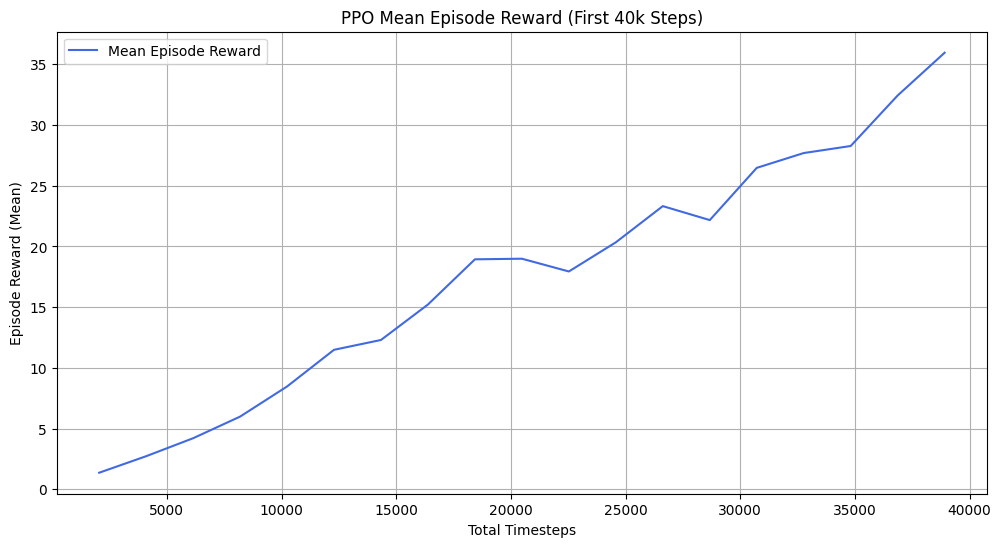

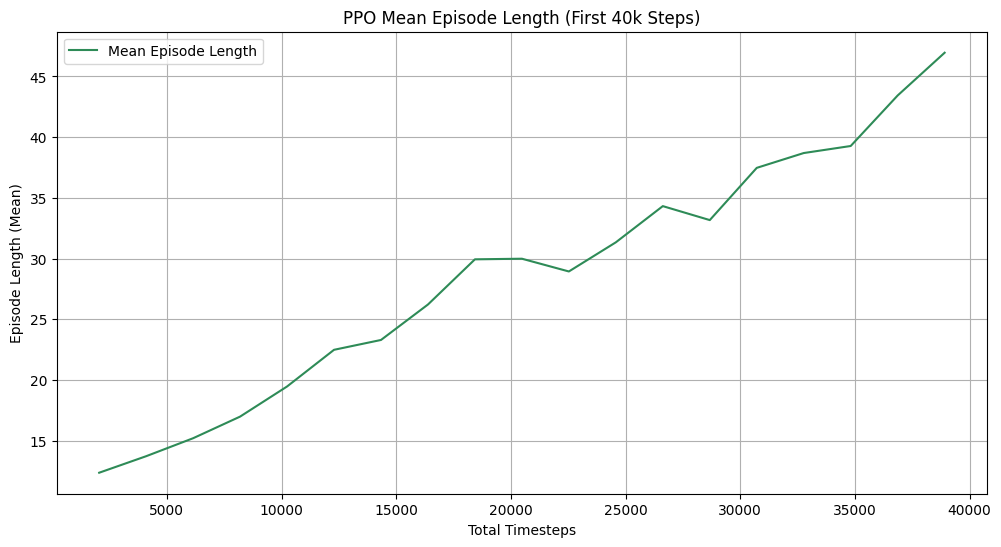

In [2]:


# Filter for first 40,000 timesteps
logs_40k = logs[logs['time/total_timesteps'] <= 40000]
# Plot: Mean Episode Reward vs. Timesteps
plt.figure(figsize=(12, 6))
plt.plot(logs_40k['time/total_timesteps'], logs_40k['rollout/ep_rew_mean'], label='Mean Episode Reward', color='royalblue')
plt.xlabel('Total Timesteps')
plt.ylabel('Episode Reward (Mean)')
plt.title('PPO Mean Episode Reward (First 40k Steps)')
plt.grid(True)
plt.legend()
plt.show()

# Plot: Episode Length vs. Timesteps
plt.figure(figsize=(12, 6))
plt.plot(logs_40k['time/total_timesteps'], logs_40k['rollout/ep_len_mean'], label='Mean Episode Length', color='seagreen')
plt.xlabel('Total Timesteps')
plt.ylabel('Episode Length (Mean)')
plt.title('PPO Mean Episode Length (First 40k Steps)')
plt.grid(True)
plt.legend()
plt.show()


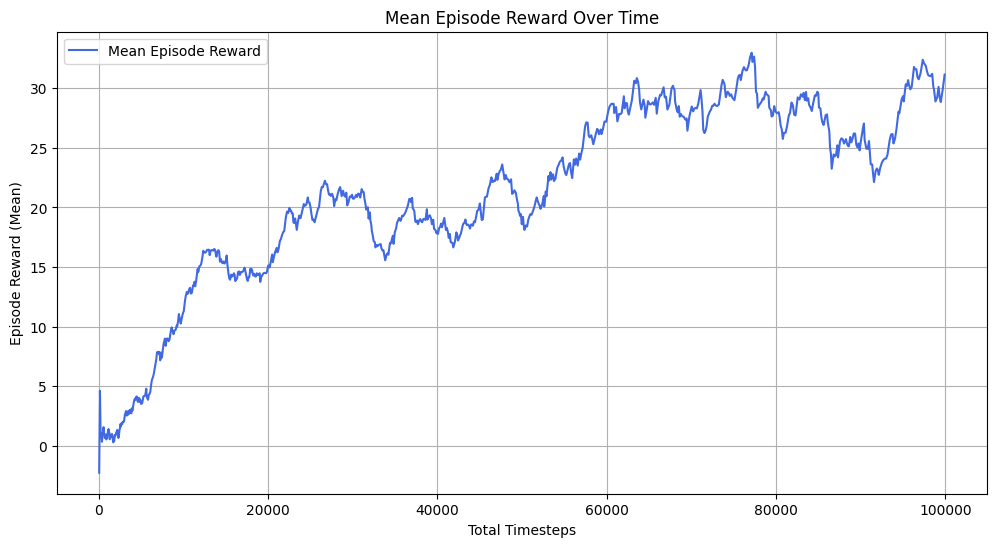

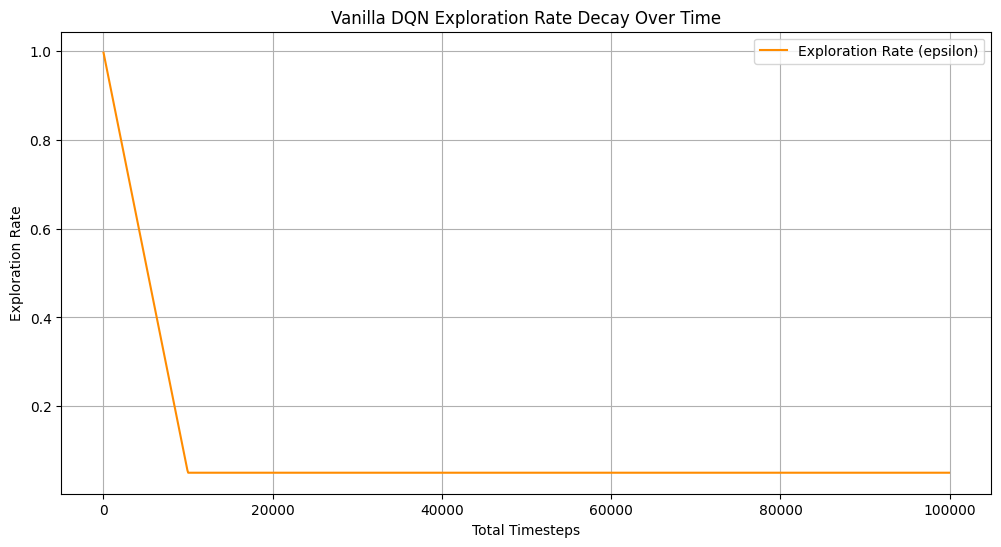

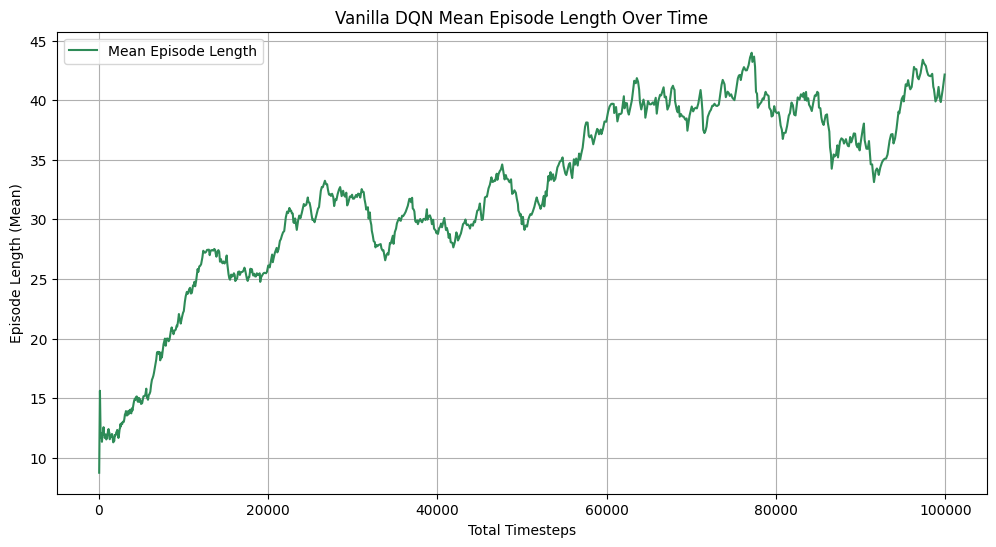

In [ ]:
# Plot: Mean Episode Reward vs. Timesteps
plt.figure(figsize=(12, 6))
plt.plot(logs['time/total_timesteps'], logs['rollout/ep_rew_mean'], label='Mean Episode Reward', color='royalblue')
plt.xlabel('Total Timesteps')
plt.ylabel('Episode Reward (Mean)')
plt.title('Mean Episode Reward Over Time')
plt.grid(True)
plt.legend()
plt.show()

# Plot: Exploration Rate vs. Timesteps
plt.figure(figsize=(12, 6))
plt.plot(logs['time/total_timesteps'], logs['rollout/exploration_rate'], label='Exploration Rate (epsilon)', color='darkorange')
plt.xlabel('Total Timesteps')
plt.ylabel('Exploration Rate')
plt.title('Vanilla DQN Exploration Rate Decay Over Time')
plt.grid(True)
plt.legend()
plt.show()

# Plot: Episode Length vs. Timesteps
plt.figure(figsize=(12, 6))
plt.plot(logs['time/total_timesteps'], logs['rollout/ep_len_mean'], label='Mean Episode Length', color='seagreen')
plt.xlabel('Total Timesteps')
plt.ylabel('Episode Length (Mean)')
plt.title('Vanilla DQN Mean Episode Length Over Time')
plt.grid(True)
plt.legend()
plt.show()
